# Atlas image postprocessing

- parse labels (distinct colors) into separate channels
- other processing: e.g. translation

In [1]:
import nilearn as ni
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import os
import numpy as np
import pandas as pd

from PIL import Image
from PIL import ImageOps
from PIL import ImagePalette

In [2]:
NLABELS = 18

image_base_dir = '/scratch/groups/jyeatman/samjohns-projects/data'
input_curv_dir = image_base_dir + '/ots-curv-mask-images-jitter'
input_parc_dir = image_base_dir + '/parc-images-jitter'
output_image_base_dir = image_base_dir + '/ots-images-jitter-processed'
output_curv_dir = output_image_base_dir + '/curv-mask'
output_parc_dir = output_image_base_dir + '/parc'

os.makedirs(output_image_base_dir, exist_ok=True)
os.makedirs(output_curv_dir, exist_ok=True)
os.makedirs(output_parc_dir, exist_ok=True)

img_fps = os.listdir(input_curv_dir)

In [3]:
dir_data = '/scratch/groups/jyeatman/samjohns-projects/data'
dir_base = dir_data + '/atlas'

dir_in_mask = dir_base + '/curv-mask'
dir_in_curv = dir_base + '/curv'
dir_in_parc = dir_base + '/parc'

dir_out_mask = dir_base + '/curv-mask-trans-trn'
dir_out_curv = dir_base + '/curv-trans-trn'
dir_out_parc = dir_base + '/parc-trans-trn'

fns_mask = os.listdir(dir_in_mask)
fns_curv = os.listdir(dir_in_curv)
fns_parc = os.listdir(dir_in_parc)

In [4]:
dirs_in = [dir_in_curv, dir_in_parc, dir_in_mask]
dirs_out = [dir_out_curv, dir_out_parc, dir_out_mask]
dirs = dirs_in + dirs_out
all([os.path.exists(s) for s in dirs])

True

In [5]:
len(fns_mask), len(fns_curv), len(fns_parc)

(94443, 93323, 93323)

In [6]:
l = [f for f in fns_curv if 'sub-' in f]

In [7]:
'sub-NDAREP505XAD-209.0-86.54-curv.png' in l

True

In [8]:
## valid for HBN

def parse(st, j):
    dcs = st[:-4].split('-')
    for i in range(len(dcs)):
        if dcs[i] == '':
            dcs[i+1] = '-' + dcs[i+1]
    dcs = [d for d in dcs if d != '']
    return dcs[j]

def parse_name(st):
    return 'sub-' + parse(st, 1)

def parse_angle1(st):
    return float(parse(st, 2))

def parse_angle2(st):
    return float(parse(st, 3))

def parse_trans1(st):
    return int(parse(st, 5))

def parse_trans2(st):
    return int(parse(st, 6))

extract_dict = {'EID': parse_name, 'Angle1': parse_angle1,
                'Angle2': parse_angle2}

extract_dict_trans = {'EID': parse_name, 'Angle1': parse_angle1,
                'Angle2': parse_angle2, 'Shift1': parse_trans1, 'Shift2': parse_trans2}

extract_dict_trans_mask = {'EID': parse_name, 'Angle1': parse_angle1,
                'Angle2': parse_angle2, 'Shift1': (lambda x: int(parse(x, 6))), 'Shift2': (lambda x: int(parse(x,7)))}

In [9]:
def make_fn_df(fn_list: list, extract_dict: dict, fn_colname: str='Filename') -> pd.DataFrame:
    df = pd.DataFrame({fn_colname: fn_list})
    for colname, extract_fn in extract_dict.items():
        df[colname] = df[fn_colname].apply(lambda x: extract_fn(x))
    return df

In [10]:
df_mask = make_fn_df(fns_mask, extract_dict, fn_colname='FilenameMask')
df_curv = make_fn_df(fns_curv, extract_dict, fn_colname='FilenameCurv')
df_parc = make_fn_df(fns_parc, extract_dict, fn_colname='FilenameParc')

df_join = pd.merge(df_mask, df_curv, how='inner', on=['EID', 'Angle1', 'Angle2'])
df_join = pd.merge(df_join, df_parc, how='inner', on=['EID', 'Angle1', 'Angle2'])

In [11]:
df_join.to_csv('../scripts/process-fns.csv', index=False)

In [12]:
t = pd.read_csv('../scripts/process-fns.csv')

In [13]:
done_curvs = os.listdir(dir_out_curv)
done_masks = os.listdir(dir_out_mask)
done_parcs = os.listdir(dir_out_parc)

df_done_mask = make_fn_df(done_masks, extract_dict_trans_mask, fn_colname='FilenameMask')
df_done_curv = make_fn_df(done_curvs, extract_dict_trans, fn_colname='FilenameCurv')
df_done_parc = make_fn_df(done_parcs, extract_dict_trans, fn_colname='FilenameParc')

df_done_join = pd.merge(df_done_mask, df_done_curv, how='inner', on=['EID', 'Angle1', 'Angle2', 'Shift1', 'Shift2'])
df_done_join = pd.merge(df_done_join, df_done_parc, how='inner', on=['EID', 'Angle1', 'Angle2', 'Shift1', 'Shift2'])

In [14]:
## valid for HBN

def parse(st, j):
    dcs = st[:-4].split('-')
    for i in range(len(dcs)):
        if dcs[i] == '':
            dcs[i+1] = '-' + dcs[i+1]
    dcs = [d for d in dcs if d != '']
    return dcs[j]

def parse_name(st):
    return 'sub-' + parse(st, 1)

def parse_angle1(st):
    return float(parse(st, 2))

def parse_angle2(st):
    return float(parse(st, 3))

def parse_trans1(st):
    return int(parse(st, 5))

def parse_trans2(st):
    return int(parse(st, 6))

extract_dict = {'EID': parse_name, 'Angle1': parse_angle1,
                'Angle2': parse_angle2}

extract_dict_trans = {'EID': parse_name, 'Angle1': parse_angle1,
                'Angle2': parse_angle2, 'Shift1': parse_trans1, 'Shift2': parse_trans2}

extract_dict_trans_mask = {'EID': parse_name, 'Angle1': parse_angle1,
                'Angle2': parse_angle2, 'Shift1': (lambda x: int(parse(x, 6))), 'Shift2': (lambda x: int(parse(x,7)))}

def make_fn_df(fn_list: list, extract_dict: dict, fn_colname: str='Filename') -> pd.DataFrame:
    
    """ Parses each filename in a list into different fields and returns them
        as a single dataframe."""
    
    df = pd.DataFrame({fn_colname: fn_list})
    for colname, extract_fn in extract_dict.items():
        df[colname] = df[fn_colname].apply(lambda x: extract_fn(x))
    return df


def get_subjects_df(directory, extract_dict=None):
    
    import os
    import pandas as pd
    
    """ Given a directory with subject-related files,
        this function parses filenames to extract data of
        the angle and shift parameters for each subject
        and to package them into a single dataframe.
        Args:
            directory (string): where to find subject files
            extract_dict (dict): which values to extract from
                each subject file, with keys the column names in
                the returned dataframe, and values the functions
                to parse out the corresponding value.
                If None (default), this extracts only EID and Angle1, Angle2.
        Returns:
            dataframe (pandas.DataFrame) with columns"""
    
    fns = os.listdir(directory)
    
    if extract_dict is None:
        extract_dict = {'EID': parse_name, 'Angle1': parse_angle1,
            'Angle2': parse_angle2}
    
    return make_fn_df(fns, extract_dict)

In [19]:
data_dir = '/scratch/groups/jyeatman/samjohns-projects/data/atlas'
curv_dir = data_dir + '/curv'
coor_dir = data_dir + '/tmp-coord-images'

fns = os.listdir(curv_dir)
fns_done = os.listdir(coor_dir)

In [16]:
sub_df = get_subjects_df(curv_dir)

In [20]:
sub_done_df = get_subjects_df(coor_dir)

In [27]:
sub_done_df['Coordinate'] = sub_done_df['Filename'].apply(lambda f: f[-5])
sub_done_zeros_df = sub_done_df[sub_done_df.Coordinate == '0']

In [30]:
sub_done_vs_orig_df = pd.merge(sub_df, sub_done_zeros_df, how='left', on=['EID', 'Angle1', 'Angle2'])

In [38]:
sub_todo_df = sub_done_vs_orig_df[sub_done_vs_orig_df.isna().any(axis=1)]

/tmp/ipykernel_1626/290312669.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_todo_df['Filename'] = sub_todo_df['Filename_x']


In [40]:
del sub_todo_df['Filename_x']

In [44]:
save_fp = '/scratch/groups/jyeatman/samjohns-projects/scripts/coord-todo.csv'
sub_todo_df.to_csv(save_fp, index=False)

In [45]:
pd.read_csv(save_fp)

,EID,Angle1,Angle2,Filename_y,Coordinate,Filename
0,sub-NDARWH725TXP,198.02,92.29,NaN,NaN,sub-NDARWH725TXP-198.02-92.29-curv.png
1,sub-NDARDL305BT8,216.60,81.48,NaN,NaN,sub-NDARDL305BT8-216.6-81.48-curv.png
2,sub-NDARBV680AA8,195.65,91.72,NaN,NaN,sub-NDARBV680AA8-195.65-91.72-curv.png
3,sub-NDARRY768ZH3,221.03,85.58,NaN,NaN,sub-NDARRY768ZH3-221.03-85.58-curv.png
4,sub-NDARBP398JHL,210.12,93.72,NaN,NaN,sub-NDARBP398JHL-210.12-93.72-curv.png
...,...,...,...,...,...,...
20452,sub-NDARBK106KRH,199.83,80.02,NaN,NaN,sub-NDARBK106KRH-199.83-80.02-curv.png
20453,sub-NDARNY205RK8,206.54,76.03,NaN,NaN,sub-NDARNY205RK8-206.54-76.03-curv.png
20454,sub-NDARLH043YDK,206.89,87.34,NaN,NaN,sub-NDARLH043YDK-206.89-87.34-curv.png
20455,sub-NDARFU789PRX,201.13,98.76,NaN,NaN,sub-NDARFU789PRX-201.13-98.76-curv.png


In [17]:
sub_df.to_csv('../scripts/coord-subs.csv', index=False)

In [18]:
pd.read_csv('/scratch/groups/jyeatman/samjohns-projects/scripts/coord-subs.csv')

,Filename,EID,Angle1,Angle2
0,sub-NDARJ257ZU2-223.8-95.11-curv.png,sub-NDARJ257ZU2,223.80,95.11
1,sub-NDARUC771VM5-219.71-82.94-curv.png,sub-NDARUC771VM5,219.71,82.94
2,sub-NDARXB704HFD-210.51-90.72-curv.png,sub-NDARXB704HFD,210.51,90.72
3,sub-NDARVP281CJ4-198.55-85.23-curv.png,sub-NDARVP281CJ4,198.55,85.23
4,sub-NDARTM501BT2-209.68-75.46-curv.png,sub-NDARTM501BT2,209.68,75.46
...,...,...,...,...
93318,sub-NDARCA690EBC-200.87-83.09-curv.png,sub-NDARCA690EBC,200.87,83.09
93319,sub-NDAREM609ZXW-213.64-91.26-curv.png,sub-NDAREM609ZXW,213.64,91.26
93320,sub-NDARHZ439EBY-199.29-87.17-curv.png,sub-NDARHZ439EBY,199.29,87.17
93321,sub-NDARJK910PDK-220.49-84.96-curv.png,sub-NDARJK910PDK,220.49,84.96


In [48]:
os.listdir('/scratch/groups/jyeatman/samjohns-projects/scripts')
#pd.read_csv('/scratch/groups/jyeatman/samjohns-projects/scripts/coord-subs.csv')

['coord-subs.csv',
 'process-fns.csv',
 'atlas-coord.py',
 'coord-todo.csv',
 'process-fns-todo.csv',
 'old',
 'test-python.py',
 'atlas-ots-curv-mask.py',
 '.ipynb_checkpoints',
 'ots-image-creation.py',
 'process-atlas-downsample-shift.py',
 'atlas-processing-initial.py',
 'atlas-processing-curv-mask.py',
 'atlas-px2vert.py']

In [181]:
df_orig_vs_done = pd.merge(df_join, df_done_join, how='left', on=['EID', 'Angle1', 'Angle2'])

In [182]:
df_todo = df_orig_vs_done[df_orig_vs_done.isnull().any(axis=1)]

In [183]:
df_todo.columns = ['FilenameMask', 'EID', 'Angle1', 'Angle2', 'FilenameCurv',
       'FilenameParc', 'FilenameMask_y', 'Shift1', 'Shift2',
       'FilenameCurv_y', 'FilenameParc_y']

In [184]:
df_td = df_todo[['FilenameMask', 'EID', 'Angle1', 'Angle2', 'FilenameCurv',
       'FilenameParc']]

In [185]:
df_td

,FilenameMask,EID,Angle1,Angle2,FilenameCurv,FilenameParc
3017,sub-NDAREP505XAD-209.00-86.54-curv-mask.png,sub-NDAREP505XAD,209.00,86.54,sub-NDAREP505XAD-209.0-86.54-curv.png,sub-NDAREP505XAD-209.0-86.54-parc.png
3018,sub-NDARTF133LLM-220.36-96.56-curv-mask.png,sub-NDARTF133LLM,220.36,96.56,sub-NDARTF133LLM-220.36-96.56-curv.png,sub-NDARTF133LLM-220.36-96.56-parc.png
3019,sub-NDARNU770PM5-224.01-96.23-curv-mask.png,sub-NDARNU770PM5,224.01,96.23,sub-NDARNU770PM5-224.01-96.23-curv.png,sub-NDARNU770PM5-224.01-96.23-parc.png
3020,sub-NDARPZ720WKW-224.15-78.29-curv-mask.png,sub-NDARPZ720WKW,224.15,78.29,sub-NDARPZ720WKW-224.15-78.29-curv.png,sub-NDARPZ720WKW-224.15-78.29-parc.png
3021,sub-NDARNF341BNN-200.89-77.94-curv-mask.png,sub-NDARNF341BNN,200.89,77.94,sub-NDARNF341BNN-200.89-77.94-curv.png,sub-NDARNF341BNN-200.89-77.94-parc.png
...,...,...,...,...,...,...
439819,sub-NDARNE511XHU-220.03-91.51-curv-mask.png,sub-NDARNE511XHU,220.03,91.51,sub-NDARNE511XHU-220.03-91.51-curv.png,sub-NDARNE511XHU-220.03-91.51-parc.png
439820,sub-NDARXZ902NFM-219.92-96.28-curv-mask.png,sub-NDARXZ902NFM,219.92,96.28,sub-NDARXZ902NFM-219.92-96.28-curv.png,sub-NDARXZ902NFM-219.92-96.28-parc.png
439821,sub-NDARKM476GFK-220.42-93.06-curv-mask.png,sub-NDARKM476GFK,220.42,93.06,sub-NDARKM476GFK-220.42-93.06-curv.png,sub-NDARKM476GFK-220.42-93.06-parc.png
439822,sub-NDARWV794VM2-222.02-98.26-curv-mask.png,sub-NDARWV794VM2,222.02,98.26,sub-NDARWV794VM2-222.02-98.26-curv.png,sub-NDARWV794VM2-222.02-98.26-parc.png


In [186]:
df_td.to_csv('../scripts/process-fns-todo.csv', index=False)

In [187]:
pd.read_csv('../scripts/process-fns-todo.csv')

,FilenameMask,EID,Angle1,Angle2,FilenameCurv,FilenameParc
0,sub-NDAREP505XAD-209.00-86.54-curv-mask.png,sub-NDAREP505XAD,209.00,86.54,sub-NDAREP505XAD-209.0-86.54-curv.png,sub-NDAREP505XAD-209.0-86.54-parc.png
1,sub-NDARTF133LLM-220.36-96.56-curv-mask.png,sub-NDARTF133LLM,220.36,96.56,sub-NDARTF133LLM-220.36-96.56-curv.png,sub-NDARTF133LLM-220.36-96.56-parc.png
2,sub-NDARNU770PM5-224.01-96.23-curv-mask.png,sub-NDARNU770PM5,224.01,96.23,sub-NDARNU770PM5-224.01-96.23-curv.png,sub-NDARNU770PM5-224.01-96.23-parc.png
3,sub-NDARPZ720WKW-224.15-78.29-curv-mask.png,sub-NDARPZ720WKW,224.15,78.29,sub-NDARPZ720WKW-224.15-78.29-curv.png,sub-NDARPZ720WKW-224.15-78.29-parc.png
4,sub-NDARNF341BNN-200.89-77.94-curv-mask.png,sub-NDARNF341BNN,200.89,77.94,sub-NDARNF341BNN-200.89-77.94-curv.png,sub-NDARNF341BNN-200.89-77.94-parc.png
...,...,...,...,...,...,...
5205,sub-NDARNE511XHU-220.03-91.51-curv-mask.png,sub-NDARNE511XHU,220.03,91.51,sub-NDARNE511XHU-220.03-91.51-curv.png,sub-NDARNE511XHU-220.03-91.51-parc.png
5206,sub-NDARXZ902NFM-219.92-96.28-curv-mask.png,sub-NDARXZ902NFM,219.92,96.28,sub-NDARXZ902NFM-219.92-96.28-curv.png,sub-NDARXZ902NFM-219.92-96.28-parc.png
5207,sub-NDARKM476GFK-220.42-93.06-curv-mask.png,sub-NDARKM476GFK,220.42,93.06,sub-NDARKM476GFK-220.42-93.06-curv.png,sub-NDARKM476GFK-220.42-93.06-parc.png
5208,sub-NDARWV794VM2-222.02-98.26-curv-mask.png,sub-NDARWV794VM2,222.02,98.26,sub-NDARWV794VM2-222.02-98.26-curv.png,sub-NDARWV794VM2-222.02-98.26-parc.png


In [79]:
counts = df_done_join.groupby(['EID', 'Angle1', 'Angle2'], as_index=False).count()

In [80]:
counts['Count'] = counts['FilenameMask']
counts = counts[['EID', 'Angle1', 'Angle2', 'Count']]

In [81]:
df_done_join_counts = pd.merge(df_done_join, counts, on=['EID', 'Angle1', 'Angle2'], how='left')

In [86]:
df_done_join_counts[df_done_join_counts.Count == 4]

,FilenameMask,EID,Angle1,Angle2,Shift1,Shift2,FilenameCurv,FilenameParc,Count
307,sub-NDARPH923FN7-201.01-103.24-curv-mask--15--...,sub-NDARPH923FN7,201.01,103.24,-15,-6,sub-NDARPH923FN7-201.01-103.24-curv--15--6.npy,sub-NDARPH923FN7-201.01-103.24-parc--15--6.npy,4
427,sub-NDARBX974XDR-197.25-82.30-curv-mask-0-0.npy,sub-NDARBX974XDR,197.25,82.30,0,0,sub-NDARBX974XDR-197.25-82.3-curv-0-0.npy,sub-NDARBX974XDR-197.25-82.3-parc-0-0.npy,4
645,sub-NDARJP948FJV-208.64-98.42-curv-mask--6-11.npy,sub-NDARJP948FJV,208.64,98.42,-6,11,sub-NDARJP948FJV-208.64-98.42-curv--6-11.npy,sub-NDARJP948FJV-208.64-98.42-parc--6-11.npy,4
697,sub-NDARMR242UKQ-207.95-99.07-curv-mask-19--2.npy,sub-NDARMR242UKQ,207.95,99.07,19,-2,sub-NDARMR242UKQ-207.95-99.07-curv-19--2.npy,sub-NDARMR242UKQ-207.95-99.07-parc-19--2.npy,4
764,sub-NDARNK005BRN-211.34-85.48-curv-mask-0-0.npy,sub-NDARNK005BRN,211.34,85.48,0,0,sub-NDARNK005BRN-211.34-85.48-curv-0-0.npy,sub-NDARNK005BRN-211.34-85.48-parc-0-0.npy,4
...,...,...,...,...,...,...,...,...,...
326393,sub-NDARUL636NGK-198.61-77.79-curv-mask-19--21...,sub-NDARUL636NGK,198.61,77.79,19,-21,sub-NDARUL636NGK-198.61-77.79-curv-19--21.npy,sub-NDARUL636NGK-198.61-77.79-parc-19--21.npy,4
326459,sub-NDARGR354WBH-200.92-88.14-curv-mask-10-11.npy,sub-NDARGR354WBH,200.92,88.14,10,11,sub-NDARGR354WBH-200.92-88.14-curv-10-11.npy,sub-NDARGR354WBH-200.92-88.14-parc-10-11.npy,4
326465,sub-NDARVC711ZK0-216.84-101.57-curv-mask-7--16...,sub-NDARVC711ZK0,216.84,101.57,7,-16,sub-NDARVC711ZK0-216.84-101.57-curv-7--16.npy,sub-NDARVC711ZK0-216.84-101.57-parc-7--16.npy,4
327108,sub-NDARPK237YHD-223.20-94.29-curv-mask--22-21...,sub-NDARPK237YHD,223.20,94.29,-22,21,sub-NDARPK237YHD-223.2-94.29-curv--22-21.npy,sub-NDARPK237YHD-223.2-94.29-parc--22-21.npy,4


In [65]:
df_todo = df_done_join_counts[df_done_join_counts['Count'] != 5]

In [70]:
df_join

,FilenameMask,EID,Angle1,Angle2,FilenameCurv,FilenameParc
0,sub-NDARHB764VZ2-207.55-93.20-curv-mask.png,sub-NDARHB764VZ2,207.55,93.20,sub-NDARHB764VZ2-207.55-93.2-curv.png,sub-NDARHB764VZ2-207.55-93.2-parc.png
1,sub-NDARWC737UJ0-202.34-93.63-curv-mask.png,sub-NDARWC737UJ0,202.34,93.63,sub-NDARWC737UJ0-202.34-93.63-curv.png,sub-NDARWC737UJ0-202.34-93.63-parc.png
2,sub-NDARCD182XT1-195.92-82.78-curv-mask.png,sub-NDARCD182XT1,195.92,82.78,sub-NDARCD182XT1-195.92-82.78-curv.png,sub-NDARCD182XT1-195.92-82.78-parc.png
3,sub-NDARNZ084JVC-206.93-89.93-curv-mask.png,sub-NDARNZ084JVC,206.93,89.93,sub-NDARNZ084JVC-206.93-89.93-curv.png,sub-NDARNZ084JVC-206.93-89.93-parc.png
4,sub-NDARVG808PKQ-217.58-87.26-curv-mask.png,sub-NDARVG808PKQ,217.58,87.26,sub-NDARVG808PKQ-217.58-87.26-curv.png,sub-NDARVG808PKQ-217.58-87.26-parc.png
...,...,...,...,...,...,...
93318,sub-NDARWE130JMG-222.83-104.75-curv-mask.png,sub-NDARWE130JMG,222.83,104.75,sub-NDARWE130JMG-222.83-104.75-curv.png,sub-NDARWE130JMG-222.83-104.75-parc.png
93319,sub-NDARJY033DKZ-211.56-84.41-curv-mask.png,sub-NDARJY033DKZ,211.56,84.41,sub-NDARJY033DKZ-211.56-84.41-curv.png,sub-NDARJY033DKZ-211.56-84.41-parc.png
93320,sub-NDARHE772FWW-210.75-80.21-curv-mask.png,sub-NDARHE772FWW,210.75,80.21,sub-NDARHE772FWW-210.75-80.21-curv.png,sub-NDARHE772FWW-210.75-80.21-parc.png
93321,sub-NDARRN598JXJ-196.75-103.28-curv-mask.png,sub-NDARRN598JXJ,196.75,103.28,sub-NDARRN598JXJ-196.75-103.28-curv.png,sub-NDARRN598JXJ-196.75-103.28-parc.png


In [73]:
len(df_join['EID'].unique())

2333

In [66]:
todo_eids = list(df_todo['EID'].unique())

In [67]:
len(todo_eids)

260

In [15]:
def get_random_shift(px, fraction=0.1):
    shift_max = int(fraction * px)
    return np.random.randint(low=-shift_max, high=shift_max, size=(2,))

In [4]:
# same parameters for all images
def crop(image):
    """ Cropping helper function.
        Assumes input has correct y dimensions and
        x dim >= y dim; trims excess x dim to make a square.
    """
    x0, y0 = image.size   
    diff = (x0 - y0) / 2
    xl, xr = diff, x0 - diff
    ltrb = (xl, 0, xr, y0)
    return image.crop(ltrb)

def resize(image, newsize=256):
    return image.resize((newsize, newsize))

def process(image, newsize=256, grayscale=True):
    """Crops image, resizes, and converts to grayscale."""
    image = crop(image)
    image = resize(image, newsize)
    if grayscale:
        image = ImageOps.grayscale(image)
    return image

In [5]:
def get_closest_color(col, pal):
    return np.abs(col - pal).sum(axis=1).argmin()

In [6]:
def to_channel_img(img, pal):
    """ Converts an image into an image with one scalar value
        for each color in a specified palette. Each pixel's
        value is determined to be the index (in the palette)
        of the color that is closest to the pixel's original
        value.
        
        Note: expects image in RGBA PNG format, e.g. image
        shape should be (x_len, y_len, 4)).
    """
    img_np = np.array(img)
    img_colors = img_np[:, :, :-1] # remove alpha channel
    s = img_np.shape  
    ret_img = np.zeros(s[:-1])
    e = np.eye(pal.shape[0])

    # loop over pixels
    for x in range(s[0]):
        for y in range(s[1]):
            px_color = img_colors[x, y]
            cc = get_closest_color(px_color, pal)
            ret_img[x, y] = cc
    return ret_img
    

In [7]:
def split(array, threshold=70, bg=255):
    T = threshold
    t = array.copy()

    t[test_np < T] = 2.0
    t[test_np >= T] = 1.0
    t[test_np == bg]= 0.0
    
    return t

def process_img(img_fp, pal, img_out_fp=None, newsize=256):
    """ Downsamples an image, converts it to a numpy array,
        resamples each pixel color to nearest color
        in a specified palette (pal),
        and saves the result as a numpy array.
        Arguments:
            img_fp: full filepath to an RGBA image
            pal: palette to resample to (np array of shape (nclrs, 3))
            img_out_fp: if None, output is not saved
            newsize: size to resize to (image should be square)
        Returns:
            the resulting np array of shape (newsize, newsize,)
            with values in the range 0, pal.shape[0] - 1
    """
    img = Image.open(img_fp)
    img = img.resize((newsize, newsize))
    
    img_channel = to_channel_img(img, pal)
    
    # save (optionally)
    if img_out_fp is not None:
        np.save(img_out_fp, img_channel)
    
    return img_channel

In [8]:
def split(array, threshold=70, bg=255):
    T = threshold
    t = array.copy()

    t[test_np < T] = 2.0
    t[test_np >= T] = 1.0
    t[test_np == bg]= 0.0
    
    return t

def process_img_mask(img_fp, pal, img_out_fp=None, newsize=256):
    """ Downsamples an image, converts it to a numpy array,
        resamples each pixel color to nearest color
        in a specified palette (pal),
        and saves the result as a numpy array.
        Arguments:
            img_fp: full filepath to an RGBA image
            pal: palette to resample to (np array of shape (nclrs, 3))
            img_out_fp: if None, output is not saved
            newsize: size to resize to (image should be square)
        Returns:
            the resulting np array of shape (newsize, newsize,)
            with values in the range 0, pal.shape[0] - 1
    """
    img = Image.open(img_fp)
    img = img.resize((newsize, newsize))
    img_channel = spit(img)
    
    # save (optionally)
    if img_out_fp is not None:
        np.save(img_out_fp, img_channel)
    
    return img_channel

In [ ]:
test_np_c = (-1) * np.ones_like(test_np)

In [10]:
def split(array, threshold=70, bg=255):
    T = threshold
    t = array.copy()

    t[test_np < T] = 2.0
    t[test_np >= T] = 1.0
    t[test_np == bg]= 0.0
    
    return t

In [11]:
def process_curv(img_fp, newsize=256, img_out_fp=None):
    """Crops image, resizes, and converts to grayscale."""
    img = Image.open(img_fp)
    img = img.resize((newsize, newsize))
    img = ImageOps.grayscale(img)
    img_np = np.array(img)
    img_np = split(img_np)
    if img_out_fp is not None:
        np.save(img_out_fp, img_np)
    return img_np

In [12]:
out_parcs = os.listdir(output_parc_dir)

In [13]:
out_parc_shapes = []
for i, p in enumerate(out_parcs):
    onp = np.load(f'{output_parc_dir}/{p}')
    out_parc_shapes.append(onp.shape)
    del onp
    if i % 500 == 0:
        print(f'loaded {i} shapes')

loaded 0 shapes


KeyboardInterrupt: 

In [27]:
ds = pd.DataFrame({'np_fn': out_parcs, 'sh': out_parc_shapes})

In [29]:
ds.head()

,np_fn,sh
0,sub-NDARMX277VHC-206.24-84.84-parc.npy,"(256, 256)"
1,sub-NDARCX021XWF-210.71-101.35-parc.npy,"(256, 256)"
2,sub-NDAREZ416XDW-208.13-88.33-parc.npy,"(256, 256)"
3,sub-NDARYU290HJ3-212.03-98.51-parc.npy,"(256, 256)"
4,sub-NDARYY218LU2-212.34-96.85-parc.npy,"(256, 256)"


In [28]:
ds[ds.sh==(21, 256, 256)]

,np_fn,sh


In [22]:
shapes = [p.shape for p in out_parc_nps]

In [15]:
len(os.listdir(output_curv_dir))

90441

In [45]:
curv_imgs = os.listdir(input_curv_dir)

In [50]:
for i, img in enumerate(curv_imgs):
    img_fp = f'{input_curv_dir}/{img}'
    out_fname = img[:-4]
    out_fp = f'{output_curv_dir}/{out_fname}'
    process_curv(img_fp, img_out_fp=out_fp)
    if i > 0 and i % 100 == 0:
        print(f'Processed {i} curvature images...')

Processed 100 curvature images...
Processed 200 curvature images...
Processed 300 curvature images...
Processed 400 curvature images...
Processed 500 curvature images...
Processed 600 curvature images...
Processed 700 curvature images...


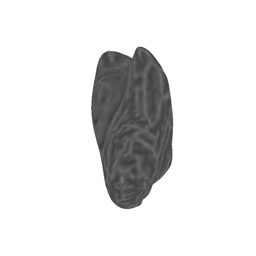

In [73]:
test_np = np.load(out_fp+'.npy')
img_test = Image.fromarray(test_np)
img_test.convert(mode='RGB')

In [20]:
input_curv_dir

'/scratch/groups/jyeatman/samjohns-projects/data/ots-curv-mask-images-jitter'

In [21]:
img_fps_curv[0]

'6029_T1.long.6029-216.69-84.75-curv-mask.png'

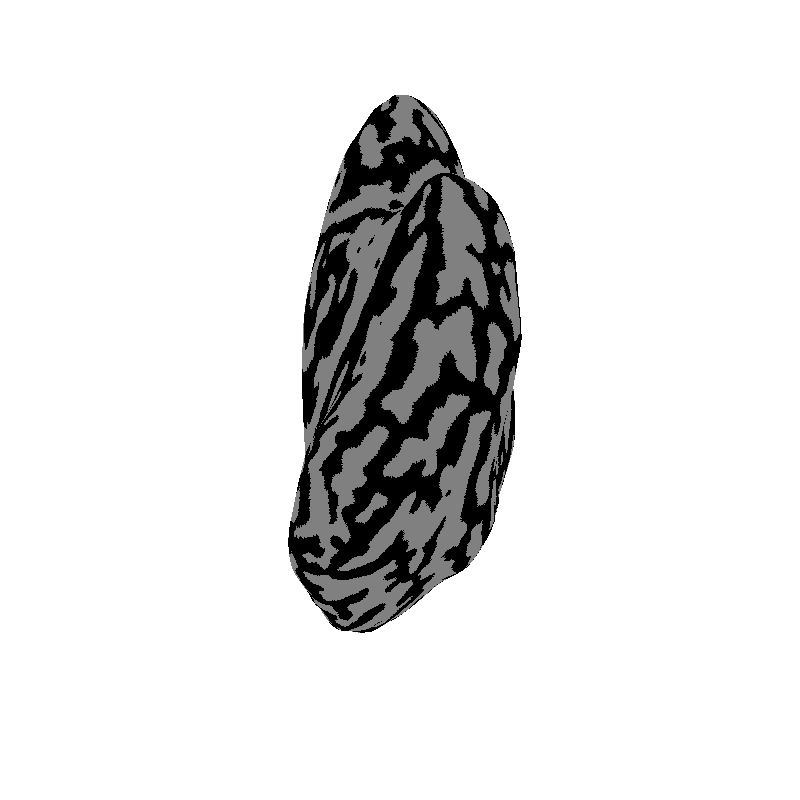

In [22]:
Image.open(f'{input_curv_dir}/{img_fps_curv[0]}')

In [27]:
def shift(xin, yin, fraction=0.1, shifts=None, channel=False, returnparams=True):
    """ Generate random shifts (translations / affine transformations)
        in np arrays that represent images.
        Assumes images are square. Can have optional channel in dim 0.
    """
    assert fraction < 1.0
    px = xin.shape[1]

    if shifts is None:
        shift_max = int(fraction * px)
        shifts = np.random.randint(low=-shift_max, high=shift_max, size=(2,))
    s1, s2 = shifts
    left = s1 < 0
    up = s2 < 0
    right = not left
    down = not up

    new_x = np.zeros_like(xin)
    new_y = np.zeros_like(yin)

    if channel:

        if left and up:
            new_x[:, 0:px + s1, 0:px + s2] = xin[:, np.abs(s1):, np.abs(s2):]
            new_y[:, 0:px + s1, 0:px + s2] = yin[:, np.abs(s1):, np.abs(s2):]
        elif left and down:
            new_x[:, 0:px + s1, s2:] = xin[:, np.abs(s1):, 0:px - s2]
            new_y[:, 0:px + s1, s2:] = yin[:, np.abs(s1):, 0:px - s2]
        elif right and up:
            new_x[:, s1:, 0:px + s2] = xin[:, 0:px - s1, np.abs(s2):]
            new_y[:, s1:, 0:px + s2] = yin[:, 0:px - s1, np.abs(s2):]
        else:
            new_x[:, s1:, s2:] = xin[:, 0:px - s1, 0:px - s2]
            new_y[:, s1:, s2:] = yin[:, 0:px - s1, 0:px - s2]

    else:  # no channel dimension

        px = xin.shape[0]
        if left and up:
            new_x[0:px + s1, 0:px + s2] = xin[np.abs(s1):, np.abs(s2):]
            new_y[0:px + s1, 0:px + s2] = yin[np.abs(s1):, np.abs(s2):]
        elif left and down:
            new_x[0:px + s1, s2:] = xin[np.abs(s1):, 0:px - s2]
            new_y[0:px + s1, s2:] = yin[np.abs(s1):, 0:px - s2]
        elif right and up:
            new_x[s1:, 0:px + s2] = xin[0:px - s1, np.abs(s2):]
            new_y[s1:, 0:px + s2] = yin[0:px - s1, np.abs(s2):]
        else:
            new_x[s1:, s2:] = xin[0:px - s1, 0:px - s2]
            new_y[s1:, s2:] = yin[0:px - s1, 0:px - s2]

    if returnparams:
        return new_x, new_y, s1, s2
    else:
        return new_x, new_y


def shift_from_file(xin_fp, yin_fp, xout_path, yout_path, niter=1, channel=False):
    """ Load .npy arrays from filepaths (including name)
        and save randomly translated versions of the same arrays in corresponding
        out directories; shift parameters will be part of save filename.
    """
    xin = np.load(xin_fp)
    yin = np.load(yin_fp)

    for i in range(niter):
        xshift, yshift, s1, s2 = shift(xin, yin, shifts=(0, 0), channel=channel)
        x_fname = (xin_fp.split('/')[-1])[:-4]
        y_fname = (yin_fp.split('/')[-1])[:-4]
        np.save(f'{xout_path}/{x_fname}-trans-{s1}-{s2}', xshift)
        np.save(f'{yout_path}/{y_fname}-trans-{s1}-{s2}', yshift)
    return

def shift_single(xin, fraction=0.1, shifts=None, channel=False, returnparams=True):
    """ Generate random shifts (translations / affine transformations)
        in np arrays that represent images.
        Assumes images are square. Can have optional channel in dim 0.
    """
    assert fraction < 1.0
    px = xin.shape[1]

    if shifts is None:
        shift_max = int(fraction * px)
        shifts = np.random.randint(low=-shift_max, high=shift_max, size=(2,))
    s1, s2 = shifts
    left = s1 < 0
    up = s2 < 0
    right = not left
    down = not up

    new_x = np.zeros_like(xin)

    if channel:

        if left and up:
            new_x[:, 0:px + s1, 0:px + s2] = xin[:, np.abs(s1):, np.abs(s2):]
        elif left and down:
            new_x[:, 0:px + s1, s2:] = xin[:, np.abs(s1):, 0:px - s2]
        elif right and up:
            new_x[:, s1:, 0:px + s2] = xin[:, 0:px - s1, np.abs(s2):]
        else:
            new_x[:, s1:, s2:] = xin[:, 0:px - s1, 0:px - s2]
 
    else:  # no channel dimension

        px = xin.shape[0]
        if left and up:
            new_x[0:px + s1, 0:px + s2] = xin[np.abs(s1):, np.abs(s2):]
        elif left and down:
            new_x[0:px + s1, s2:] = xin[np.abs(s1):, 0:px - s2]
        elif right and up:
            new_x[s1:, 0:px + s2] = xin[0:px - s1, np.abs(s2):]
        else:
            new_x[s1:, s2:] = xin[0:px - s1, 0:px - s2]
            
    if returnparams:
        return new_x, s1, s2
    else:
        return new_x

In [15]:
val_fns = os.listdir('../data/parc-images-jitter-processed/vertex-maps-val-2')
val_fns = [fn for fn in val_fns if 'vx2coord' in fn]

df_vals = pd.DataFrame({'Filename': val_fns})
df_vals['EID'] = df_vals['Filename'].apply(lambda x: parse_name(x))
df_vals['Angle1'] = df_vals['Filename'].apply(lambda x: parse_angle1(x))
df_vals['Angle2'] = df_vals['Filename'].apply(lambda x: parse_angle2(x))
df_vals['Trans1'] = df_vals['Filename'].apply(lambda x: parse_trans1(x))
df_vals['Trans2'] = df_vals['Filename'].apply(lambda x: parse_trans2(x))

base_dir = '/scratch/groups/jyeatman/samjohns-projects/data'
atlas_dir = '/scratch/groups/jyeatman/samjohns-projects/data/atlas'
in_parc = os.listdir(atlas_dir + '/parc')
in_curv = os.listdir(atlas_dir + '/curv')
df_in = pd.DataFrame({'Filename': in_parc})
df_in['EID'] = df_in['Filename'].apply(lambda x: parse_name(x))
df_in['Angle1'] = df_in['Filename'].apply(lambda x: parse_angle1(x))
df_in['Angle2'] = df_in['Filename'].apply(lambda x: parse_angle2(x))

out_parc_val = atlas_dir + '/parc-trans-val'
out_parc_trn = atlas_dir + '/parc-trans-trn'
out_curv_val = atlas_dir + '/curv-trans-val'
out_curv_trn = atlas_dir +'/curv-trans-trn'
out_curv_mask_val = atlas_dir + '/curv-mask-trans-val'
out_curv_mask_trn = atlas_dir + '/curv-mask-trans-trn'

os.makedirs(out_parc_val, exist_ok=True)
os.makedirs(out_parc_trn, exist_ok=True)
os.makedirs(out_curv_val, exist_ok=True)
os.makedirs(out_curv_trn, exist_ok=True)
os.makedirs(out_curv_mask_val, exist_ok=True)
os.makedirs(out_curv_mask_trn, exist_ok=True)

in_mask_dir = base_dir + '/curv-mask-jitter'
merge_df = pd.merge(df_in, df_vals, on=['EID', 'Angle1', 'Angle2'], how='inner')
subjects_val = list(merge_df['EID'].unique())

In [26]:
df_vals

,Filename,EID,Angle1,Angle2,Trans1,Trans2
0,sub-NDARCJ363KLE-204.52-102.01--25-1-vx2coord.pkl,sub-NDARCJ363KLE,204.52,102.01,-25,1
1,sub-NDARZG236AUT-214.74-84.74--21-6-vx2coord.pkl,sub-NDARZG236AUT,214.74,84.74,-21,6
2,sub-NDARTR840XP1-218.42-80.64-16--7-vx2coord.pkl,sub-NDARTR840XP1,218.42,80.64,16,-7
3,sub-NDARKL223LLF-199.45-83.25--12-20-vx2coord.pkl,sub-NDARKL223LLF,199.45,83.25,-12,20
4,sub-NDARXF890FLA-217.34-85.92-0-0-vx2coord.pkl,sub-NDARXF890FLA,217.34,85.92,0,0
...,...,...,...,...,...,...
21422,sub-NDARJK842BCN-199.82-100.45--16--3-vx2coord...,sub-NDARJK842BCN,199.82,100.45,-16,-3
21423,sub-NDARUU991VRE-213.22-98.99-9-7-vx2coord.pkl,sub-NDARUU991VRE,213.22,98.99,9,7
21424,sub-NDARAG191AE8-221.03-91.05--19--3-vx2coord.pkl,sub-NDARAG191AE8,221.03,91.05,-19,-3
21425,sub-NDARRL660CME-202.45-87.8--20--25-vx2coord.pkl,sub-NDARRL660CME,202.45,87.80,-20,-25


In [16]:
fn = merge_df['Filename_x'][0]

In [18]:
len(in_parc)

93323

In [ ]:
img = Image.open(f'{atlas_dir}/parc/{fn}')


In [ ]:
def downsample_and_shift(img_fp, img_out_fp, pal, shifts, apply_to_channel=False, newsize=256):
    """ Downsamples an image, converts it to a numpy array,
        resamples each pixel color to nearest color
        in a specified palette (pal),
        and saves the result as a numpy array.
        Arguments:
            img_fp: full filepath to an RGBA image
            pal: palette to resample to (np array of shape (nclrs, 3))
            img_out_fp: if None, output is not saved
            newsize: size to resize to (image should be square)
        Returns:
            the resulting np array of shape (newsize, newsize,)
            with values in the range 0, pal.shape[0] - 1
    """
    img = Image.open(img_fp)
    img = img.resize((newsize, newsize))
    
    if apply_to_channel:
        img = to_channel_img(img, pal)
        
    for s in shifts:
        img_s = shift_single(img, shifts=s)
        np.save(img_out_fp, img_s)
        
    return

In [80]:
fn0 = merge_df['Filename_x'][0]

In [81]:
parc_fns = merge_df[merge_df['Filename_x']==fn0]

In [86]:
for a in parc_fns:
    print(a)

Filename_x
EID
Angle1
Angle2
Filename_y
Trans1
Trans2


In [90]:
t1 = list(parc_fns['Trans1'])
t2 = list(parc_fns['Trans2'])
zip(t1, t2)

In [ ]:
for fn in fns:
    
    parc_fns = merge_df[merge_df['Filename_x']==fn]
    t1 = list(parc_fns['Trans1'])
    t2 = list(parc_fns['Trans2'])
    in_path = f'{atlas_dir}/parc/{fn}'
    out_path = f'{out_parc_val}/{fn}-{a}-{b}'
    for a, b in zip(t1, t2):
        downsample_and_shift(in_path, out_path, shifts=[a, b])

In [20]:
import pickle

In [23]:
merge_df

,Filename_x,EID,Angle1,Angle2,Filename_y,Trans1,Trans2
0,sub-NDARVG132NF6-195.4-94.14-parc.png,sub-NDARVG132NF6,195.40,94.14,sub-NDARVG132NF6-195.4-94.14-11--3-vx2coord.pkl,11,-3
1,sub-NDARVG132NF6-195.4-94.14-parc.png,sub-NDARVG132NF6,195.40,94.14,sub-NDARVG132NF6-195.4-94.14-4--11-vx2coord.pkl,4,-11
2,sub-NDARVG132NF6-195.4-94.14-parc.png,sub-NDARVG132NF6,195.40,94.14,sub-NDARVG132NF6-195.4-94.14--18-4-vx2coord.pkl,-18,4
3,sub-NDARPB619PHV-212.7-99.86-parc.png,sub-NDARPB619PHV,212.70,99.86,sub-NDARPB619PHV-212.7-99.86--18-14-vx2coord.pkl,-18,14
4,sub-NDARPB619PHV-212.7-99.86-parc.png,sub-NDARPB619PHV,212.70,99.86,sub-NDARPB619PHV-212.7-99.86-8--4-vx2coord.pkl,8,-4
...,...,...,...,...,...,...,...
21250,sub-NDARJK842BCN-214.61-84.77-parc.png,sub-NDARJK842BCN,214.61,84.77,sub-NDARJK842BCN-214.61-84.77-1--5-vx2coord.pkl,1,-5
21251,sub-NDARGV948BFZ-210.06-89.35-parc.png,sub-NDARGV948BFZ,210.06,89.35,sub-NDARGV948BFZ-210.06-89.35--3-3-vx2coord.pkl,-3,3
21252,sub-NDARGV948BFZ-210.06-89.35-parc.png,sub-NDARGV948BFZ,210.06,89.35,sub-NDARGV948BFZ-210.06-89.35-0-0-vx2coord.pkl,0,0
21253,sub-NDARGV948BFZ-210.06-89.35-parc.png,sub-NDARGV948BFZ,210.06,89.35,sub-NDARGV948BFZ-210.06-89.35-4--5-vx2coord.pkl,4,-5


In [22]:
with open('../scripts/')

['atlas-coord.py',
 'old',
 'test-python.py',
 'atlas-ots-curv-mask.py',
 '.ipynb_checkpoints',
 'ots-image-creation.py',
 'atlas-processing-initial.py',
 'atlas-processing-curv-mask.py',
 'atlas-px2vert.py']

In [ ]:
with open('../scripts/')